In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cocods:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1259814%2F2100424%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240420%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240420T070502Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1f33173d94a446db24d6f1765abda5ce88403453fca1243c006248cc26db30dbfd7f43e781dc5d2032b13cd0d4e21e4b3d093ee56d160bdc79851777daf5d785a025c320ac8813bc5ebb37c6e4a9cf32504c8baee69e02bb90afd67b7914f445f3089851f801dae0dd84e0f1736a6b226358d7b5a9645694dc280b5ef677a7029d45a74471cc7408050c3b66e328b168fe330f63c9acf0b1baf5461cae38895848f922338c0b6be414a95ae41a8e2b12f76fd8c6cb89aa7908efdbcc382505a7ba49e97e27ed51f4af265ad17811c3214ab55b6b94ffcedff973f455bb19b6dc7924db9af09f5db8827cb2f25aaf4ecc1ce8a8df9514d40206899d5b6c120a8c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 20279000593 bytes downloaded
Downloaded and uncompressed: cocods
Data source import complete.


In [ ]:
# !pip install pycocotools

from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical

from keras.layers import add

from keras.models import Model, load_model

from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Exploring COCO Dataset



# Preprocess and tokenize the captions

#### Find Categories

loading annotations into memory...
Done (t=32.95s)
creating index...
index created!


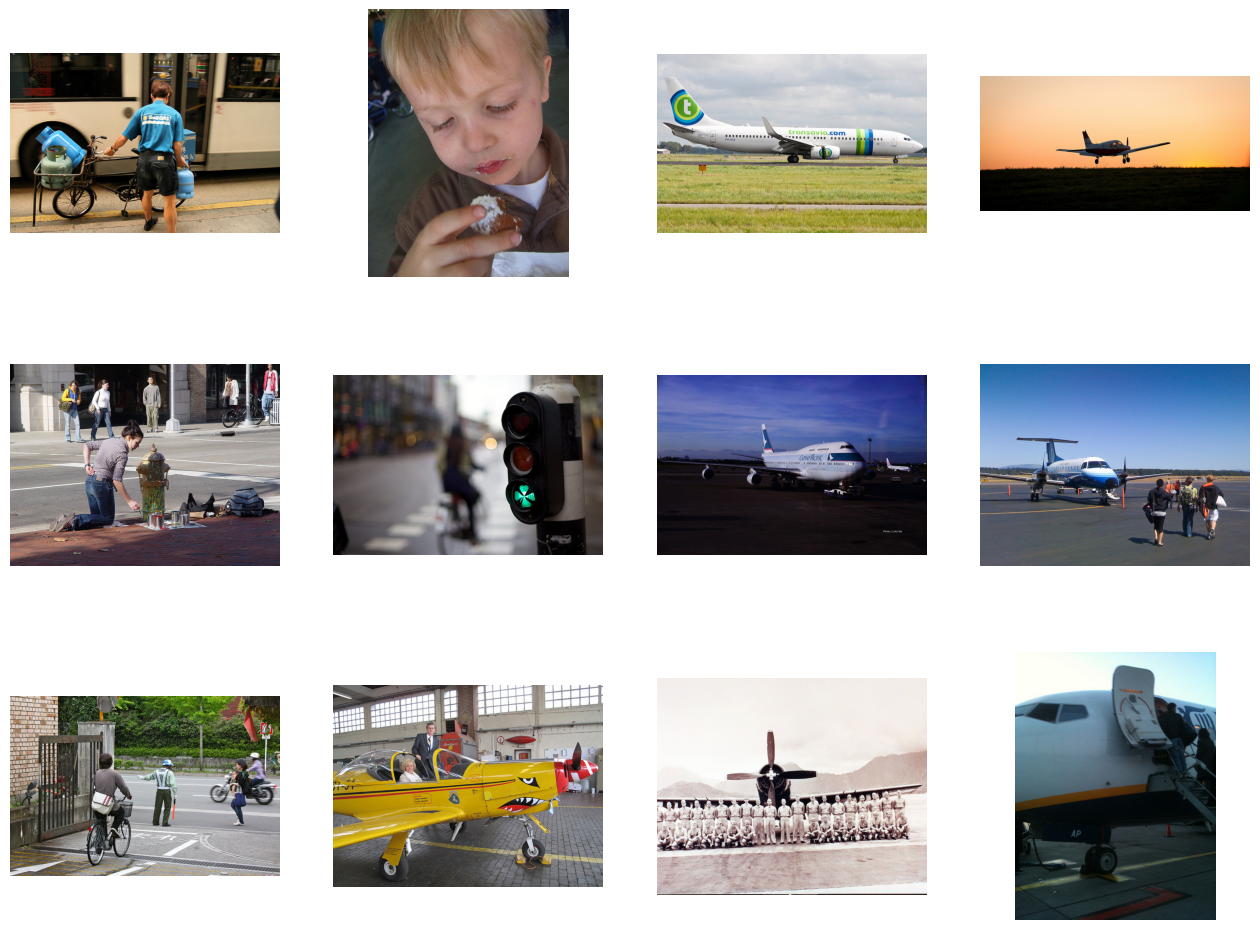

In [ ]:
coco= COCO("../input/cocods/annotations_trainval2017/annotations/instances_train2017.json")
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

subcategories = [cat['name'] for cat in cats]


catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds:
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img

length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
train_cats = subcategories_imageIds['bicycle'] + subcategories_imageIds['airplane']
imgIdss = coco.getImgIds(imgIds = train_cats)
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):

    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

In [ ]:
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

#### Find Sub Categories

In [ ]:
subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

Number of main categories:  12
List of main categories:  ['food', 'animal', 'sports', 'outdoor', 'vehicle', 'indoor', 'appliance', 'kitchen', 'accessory', 'person', 'electronic', 'furniture']
Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toas

#### Find Sub categories with its corresponding IDs

In [ ]:
catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

Sub categories with IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'c

#### Find total images with each sub categories

In [ ]:
subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds:
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img

print("Sub categories with Image IDs :",len(subcategories_imageIds))

Sub categories with Image IDs : 80


In [ ]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in each sub categories: ", length_dict)

Total images in each sub categories:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch': 44

In [ ]:
train_cats = subcategories_imageIds['bicycle'] + subcategories_imageIds['airplane']
imgIdss = coco.getImgIds(imgIds = train_cats)
print("Total Images: ", len(imgIdss))

Total Images:  6221


#### Load some of the random images

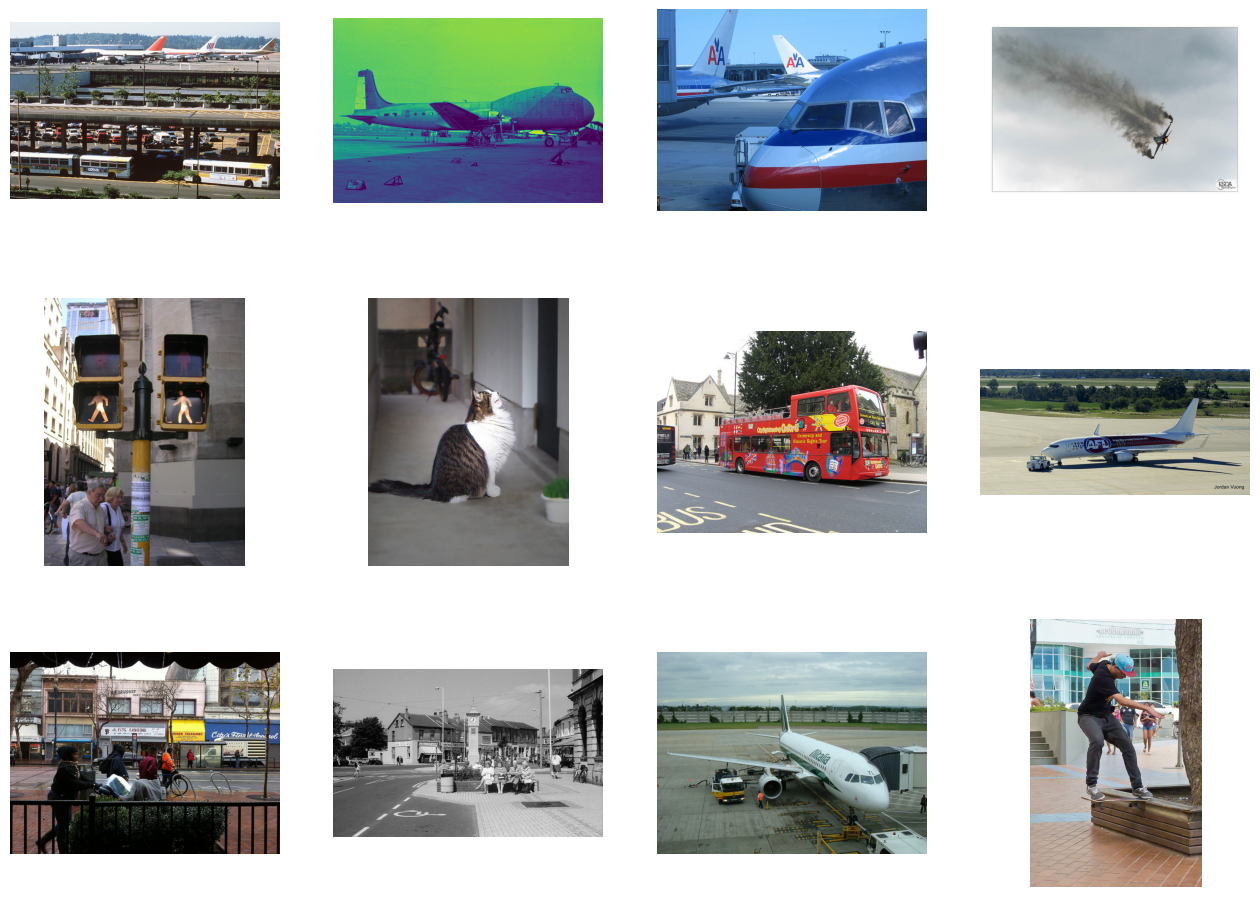

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):

    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

#### Load images with keypoints objects

In [ ]:
annFile = "../input/cocods/annotations_trainval2017/annotations/person_keypoints_train2017.json"
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=15.53s)
creating index...
index created!


#### Load images with respective captions

In [ ]:
annFile = "../input/cocods/annotations_trainval2017/annotations/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=2.28s)
creating index...
index created!


a dog laying on a wooden step near a house
there is a white and brown dog sitting on the steps
A dog that is sitting on a wooden patio next to some shoes.
THERE IS A DOG LYING ON THE STEP 
A dog is laying on the wooden porch stairs.


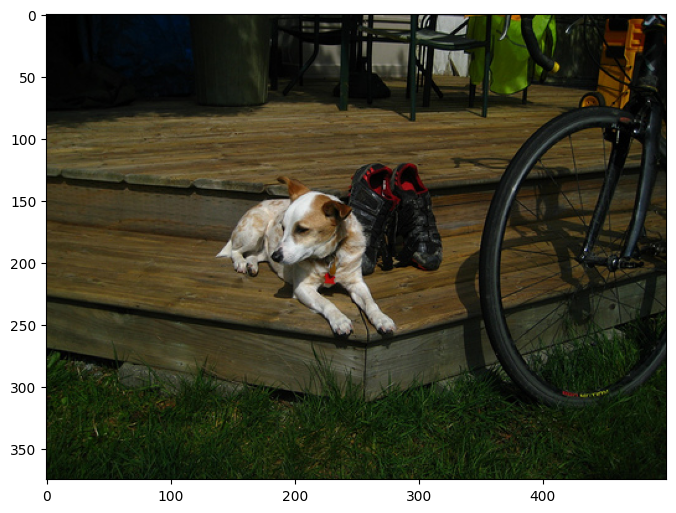

In [ ]:
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

In [ ]:
img = coco.loadImgs(next_pix[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

In [ ]:
img = coco.loadImgs(next_pix[10])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

# Image caption generator
#### Here I have taken "Bicycle" and "Airplane" images and captions only.


In [ ]:
print("Total images for training: ", len(imgIdss))
print(type(imgIdss[0]))


Total images for training:  6221
<class 'int'>


In [ ]:
from sklearn.model_selection import train_test_split

# Define the image IDs you want to split
image_ids = imgIdss  # Assuming imgIdss contains the image IDs you want to split

# Split the image IDs into 70% train and 30% test
train_ids, test_ids = train_test_split(image_ids, test_size=0.3, random_state=42)

print("Total images for training:", len(train_ids))
print("Total images for testing:", len(test_ids))
print(type(train_ids[0]))

Total images for training: 4354
Total images for testing: 1867
<class 'int'>


# Prepare Dataset

#### Group all captions together having the same image and store them in dict.

In [ ]:
dataset = dict()
imgcaptions = []

for imgid in train_ids:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:

        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))

        # Replace - to blank
        cap = cap.replace("-"," ")

        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]

        # join word list into sentence and <start> and <end> tag to each sentence which helps
        # LSTM encoder-decoder model while training.

        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)

    dataset[img['coco_url']] = imgcaptions


print("Length of Dataset: ",len(dataset))


Length of Dataset:  4354


In [ ]:
from itertools import chain
flatten_list = list(chain.from_iterable(dataset.values()))

tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)
print("Bicycle ID: ", tokenizer.word_index['bicycle'])
print("Airplane ID: ", tokenizer.word_index['airplane'])

Vocabulary length:  5415
Bicycle ID:  27
Airplane ID:  13


In [ ]:
!pip install transformers
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mh14ldk_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mh14ldk_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 798.1 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [ ]:
import clip

In [ ]:
clip_model, preprocess = clip.load("ViT-B/32",jit=False)

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 31.9MiB/s]


In [ ]:
import torch
device = torch.device("cuda:0")
print("Using GPU:", torch.cuda.get_device_name(device))

Using GPU: Tesla T4


In [ ]:
import gc
gc.collect()

318

In [ ]:
import torch
from tqdm import tqdm
from PIL import Image
from skimage import io

# Assuming preprocess and clip_model are defined elsewhere
# Define preprocess and clip_model accordingly

batch_size = 32  # You can adjust the batch size as needed

image_features = {}
img_paths = list(dataset.keys())

# Process images in batches
for i in tqdm(range(0, len(img_paths), batch_size)):
    batch_img_paths = img_paths[i:i + batch_size]
    batch_images = [io.imread(img_path) for img_path in batch_img_paths]
    batch_pil_images = [Image.fromarray(img) for img in batch_images]
    batch_inputs = torch.stack([preprocess(img).unsqueeze(0) for img in batch_pil_images]).to(device)
    batch_inputs = batch_inputs.squeeze(1)

    with torch.no_grad():
        batch_features = clip_model.encode_image(batch_inputs).to(device, dtype=torch.float32)

    for img_path, feature in zip(batch_img_paths, batch_features):
        image_features[img_path] = feature

print("Image features length: ", len(image_features))


100%|██████████| 137/137 [16:46<00:00,  7.35s/it]

Image features length:  4354


In [ ]:
import numpy as np

# Initialize an empty dictionary to store the converted features
image_features_np = {}

# Iterate through the image_features dictionary
for img_path, feature in image_features.items():
    # Convert the feature to a NumPy array and reshape it
    feature_np = feature.cpu().numpy().reshape(1, -1)

    # Store the converted feature in the new dictionary
    image_features_np[img_path] = feature_np

print("Image features length (after conversion):", len(image_features_np))


Image features length (after conversion): 4354


In [ ]:
image_features_np['http://images.cocodataset.org/train2017/000000047084.jpg'].shape

KeyError: 'http://images.cocodataset.org/train2017/000000047084.jpg'

In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(dataset)

In [ ]:
#create input-output sequence pairs from the image description.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]

            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)


def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()

    # walk through each description for the image
    for desc in desc_list:

        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]

        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):

            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]

            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]

            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output

    return np.array(X1), np.array(X2), np.array(y)


In [ ]:
from keras.utils import plot_model

# define the captioning model
def define_model(total_words, max_length):

    # features from the Clip squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(512,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [ ]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

print('Dataset: ', len(dataset))
print('Descriptions: train=', len(dataset))
print('Photos: train=', len(image_features))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

model = define_model(total_words, max_length)

# Load the previously saved weights if available
if os.path.exists('/content/drive/MyDrive/models/model_0 (2)'):
    print("Loading model weights from checkpoint...")
    model.load_weights('/content/drive/MyDrive/models/model_0 (2)')

epochs = 1
steps = len(dataset)
batch_size = 32
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/models/model_0 (2)',
                               verbose=1)
# Make a directory models to save our models
import os
os.mkdir("nmodel6")
save_path = "/content/drive/MyDrive/models"

for i in range(epochs):
    generator = data_generator(dataset, image_features_np, tokenizer, max_length)
    model.fit(generator, epochs=300, steps_per_epoch=steps//batch_size, callbacks=[checkpointer], verbose=1)
    model.save(save_path + "model_" + str(i) + ".h5")



Dataset:  4354
Descriptions: train= 4354
Photos: train= 4354
Vocabulary Size: 5415
Description Length:  46
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 46)]                 0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 46, 256)              1386240   ['input_10[0][0]']            
                                                                                                  
 dropout_8 (Dropout)         (None, 512)                  0         ['input_9[0][0]'

136/136 [==============================] - 44s 325ms/step - loss: 3.6736
Epoch 12/300
136/136 [==============================] - ETA: 0s - loss: 3.6193
Epoch 12: saving model to /content/drive/MyDrive/models/model_0 (2)
136/136 [==============================] - 25s 185ms/step - loss: 3.6193
Epoch 13/300
136/136 [==============================] - ETA: 0s - loss: 3.5772
Epoch 13: saving model to /content/drive/MyDrive/models/model_0 (2)
136/136 [==============================] - 25s 184ms/step - loss: 3.5772
Epoch 14/300
136/136 [==============================] - ETA: 0s - loss: 3.5074
Epoch 14: saving model to /content/drive/MyDrive/models/model_0 (2)
136/136 [==============================] - 25s 183ms/step - loss: 3.5074
Epoch 15/300
136/136 [==============================] - ETA: 0s - loss: 3.4391
Epoch 15: saving model to /content/drive/MyDrive/models/model_0 (2)
136/136 [==============================] - 25s 187ms/step - loss: 3.4391
Epoch 16/300
136/136 [=========================

# BLEU SCORE


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import PIL


def extract_features(filename, model):
    image = io.imread(img)
    pil_image = Image.fromarray(image)
    imge = preprocess(pil_image).unsqueeze(0).to(device)

    feature = clip_model.encode_image(imge).to(device, dtype=torch.float32)
    feature_np  = feature.detach().cpu().numpy().reshape(1, -1)
    return feature



def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)

        if word is None:
            break
        in_text += ' ' + word

        if word == 'end':
            break
    return in_text




In [ ]:
valdataset = dict()
imgcaptions = []

for imgid in test_ids:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:

        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))

        # Replace - to blank
        cap = cap.replace("-"," ")

        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]

        # join word list into sentence and <start> and <end> tag to each sentence which helps
        # LSTM encoder-decoder model while training.

        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)

    valdataset[img['coco_url']] = imgcaptions




In [ ]:
import torch
from PIL import Image


valimage_features = {}
img_paths = []
n=0
for img in tqdm(valdataset.keys()):
  if(n<50):
    image = io.imread(img)
    pil_image = Image.fromarray(image)
    imge = preprocess(pil_image).unsqueeze(0).to(device)

    feature = clip_model.encode_image(imge).to(device, dtype=torch.float32)
    feature_np  = feature.detach().cpu().numpy().reshape(1, -1)
    valimage_features[img] = feature_np
    img_paths.append(img)
  n=n+1

print("Image features length: ", len(valimage_features))

In [ ]:
reference_description= []
generated_description = []

model = load_model("/content/drive/MyDrive/models/model_0 (2).h5")
for i in img_paths:

  photo =  valimage_features[i]
  reference=[caption.split() for caption in valdataset[i]]
  generated = generate_desc(model, tokenizer, photo, max_length)
  generated = generated.split()

  reference_description.append(reference)
  generated_description.append(generated)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(reference_description, generated_description, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(reference_description, generated_description, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(reference_description, generated_description, weights=(0.33, 0.33, 0.33, 0)))
print('BLEU-4: %f' % corpus_bleu(reference_description, generated_description, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.388988
BLEU-2: 0.184721
BLEU-3: 0.078171
BLEU-4: 0.032167


In [ ]:
print(img_paths[0])

http://images.cocodataset.org/train2017/000000469728.jpg


loading annotations into memory...
Done (t=1.12s)
creating index...
index created!


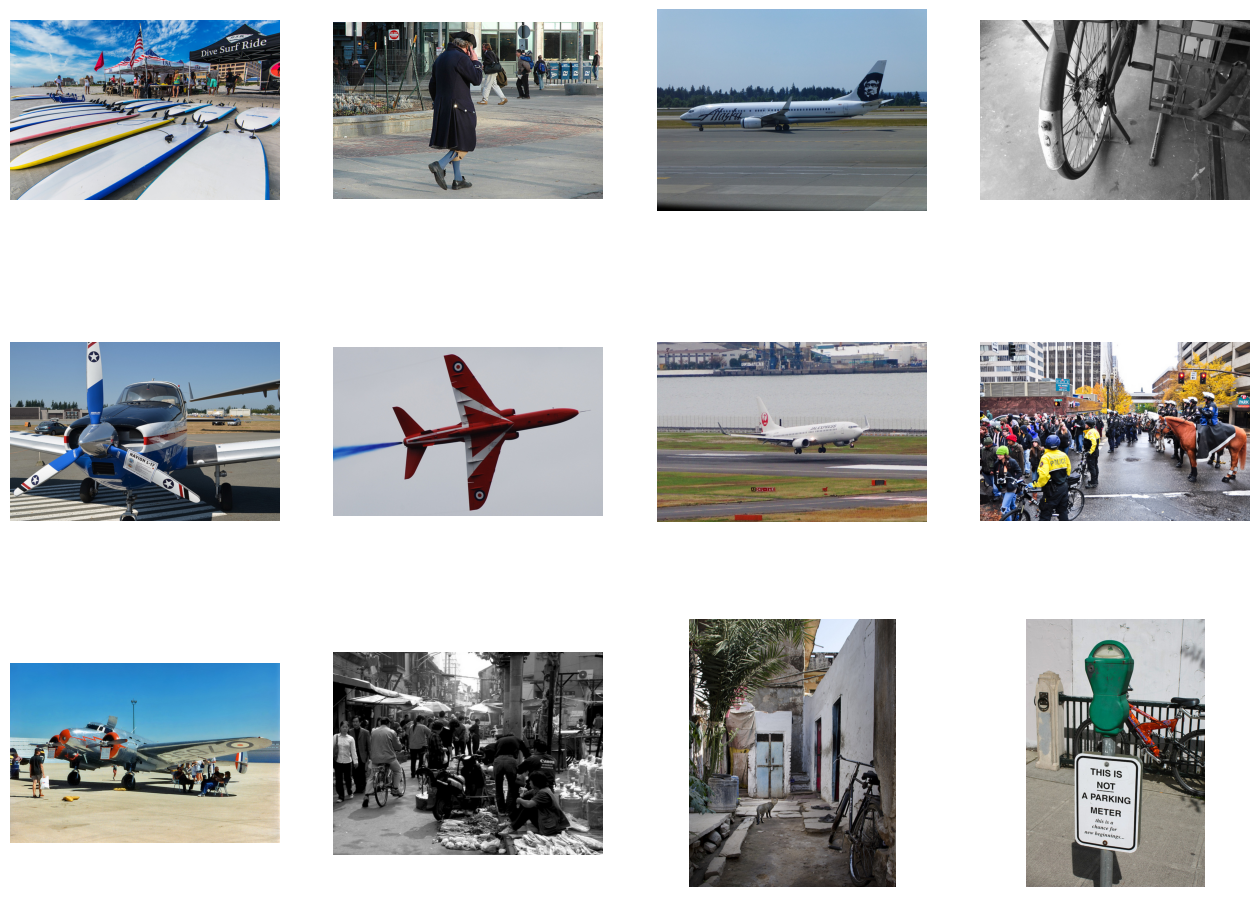

In [ ]:
coco1= COCO("../input/cocods/annotations_trainval2017/annotations/instances_val2017.json")
cats1 = coco1.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats1]))

subcategories1 = [cat['name'] for cat in cats1]


catIds1 = coco.getCatIds(catNms=subcategories1)

subcategories_Ids1 = dict()
for i in range(0,len(subcategories1)):
    subcategories_Ids1[subcategories1[i]] = catIds[i]

subcategories_imageIds1 = dict()

for i in range(0,len(catIds1)):
    imgIds1 = coco.getImgIds(catIds=catIds1[i])
    img = []
    for j in imgIds1:
        img.append(j)
    subcategories_imageIds1[subcategories1[i]] = img

length_dict = {key: len(value) for key, value in subcategories_imageIds1.items()}
train_cats = subcategories_imageIds1['bicycle'] + subcategories_imageIds1['airplane']
imgIdss1 = coco.getImgIds(imgIds = train_cats)
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss1
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):

    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

In [ ]:
print(imgIdss1)

[307842, 466247, 105096, 162763, 247, 59551, 186201, 327663, 42977, 426585, 484661, 120595, 531309, 511279, 177755, 10097, 217571, 104588, 354235, 244206, 427435, 377493, 131581, 405078, 108069, 239771, 385589, 103393, 162256, 12283, 454565, 247971, 168558, 85173, 351419, 142000, 538194, 495580, 572251, 116048, 536833, 79392, 280271, 147698, 474067, 579484, 462833, 487466, 438029, 87100, 570783, 85488, 419105, 509822, 146659, 343059, 518850, 445388, 220666, 362499, 274631, 424596, 255158, 134176, 484650, 124739, 190964, 320641, 389681, 11294, 538242, 296344, 447602, 306936, 529667, 179860, 268798, 277319, 13279, 393542, 158486, 73437, 566364, 11842, 390334, 296775, 82201, 129065, 151576, 507580, 546261, 341420, 57745, 482810, 524577, 442771, 413419, 385971, 232548, 493227, 451768, 10342, 158795, 186646, 54766, 274248, 528243, 57213, 215819, 258078, 340252, 446813, 140976, 472788, 144992, 252280, 531937, 307567, 454951, 358361, 564643, 456695, 499584, 453496, 538249, 102319, 61535, 2616

In [ ]:
annFile = "../input/cocods/annotations_trainval2017/annotations/captions_val2017.json"
coco_caps=COCO(annFile)
anns = coco_caps.loadAnns(22396)
coco_caps.showAnns(anns)
plt.show()

KeyError: '../input/cocods/val2017/val2017/000000134176.jpg'




start a large jetliner flying over a large city end


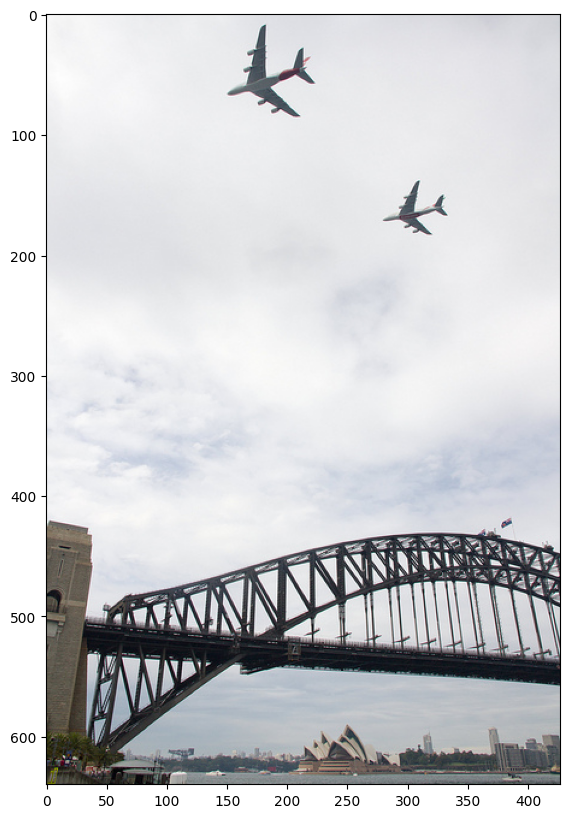

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import PIL

def extract_features(filename, model):
    image = io.imread(filename)  # assuming `filename` is the correct variable
    pil_image = Image.fromarray(image)
    imge = preprocess(pil_image).unsqueeze(0).to(device)

    feature = clip_model.encode_image(imge).detach().cpu().numpy().reshape(1, -1)
    return tf.convert_to_tensor(feature, dtype=tf.float32)

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)

        if word is None:
            break
        in_text += ' ' + word

        if word == 'end':
            break
    return in_text

# Assuming you have imported/load tokenizer and max_length from somewhere
model = load_model("/content/drive/MyDrive/models/model_0 (2).h5")
photo = extract_features("../input/cocods/val2017/val2017/000000001761.jpg", clip_model)
img = Image.open("../input/cocods/val2017/val2017/000000001761.jpg")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)





start a large jetliner flying through a blue sky end


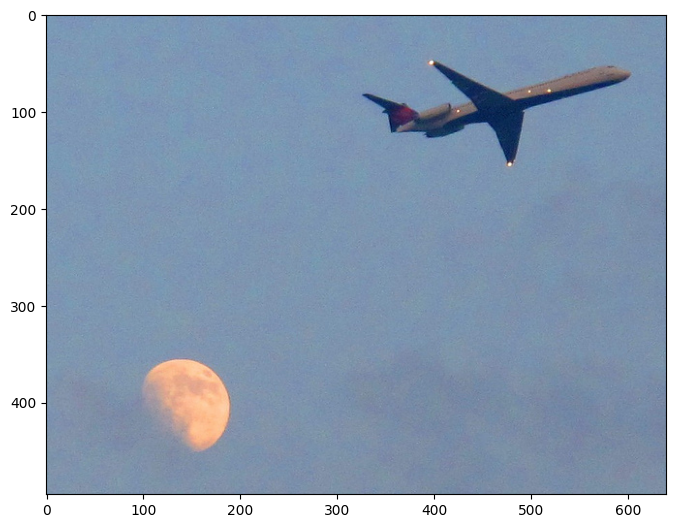

In [ ]:
model = load_model("/content/drive/MyDrive/models/model_0 (2).h5")
photo = extract_features("../input/cocods/val2017/val2017/000000022396.jpg", clip_model)
img = Image.open("../input/cocods/val2017/val2017/000000022396.jpg")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start a bike parked on the side of the road end


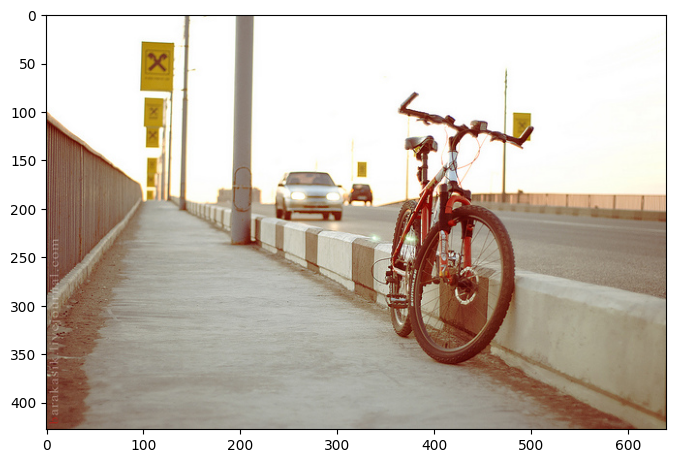

In [ ]:
model = load_model("/content/drive/MyDrive/models/model_0 (2).h5")
photo = extract_features("../input/cocods/val2017/val2017/000000224051.jpg", clip_model)
img = Image.open("../input/cocods/val2017/val2017/000000224051.jpg")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start a cat sitting on a bench with a bicycle end


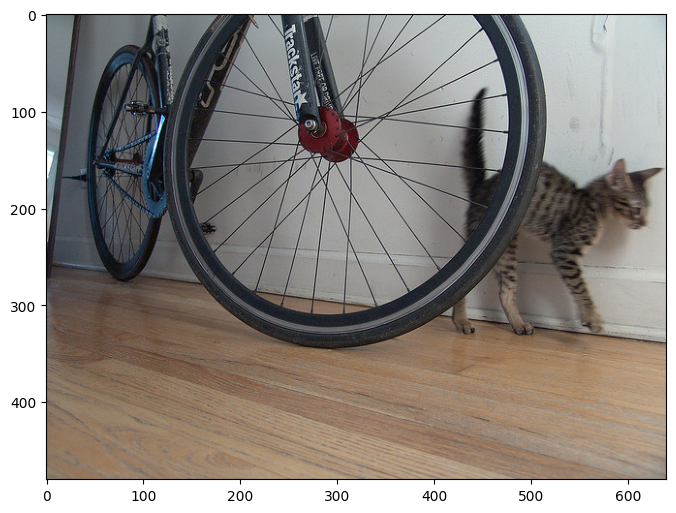

In [ ]:
model = load_model("/content/drive/MyDrive/models/model_0 (2).h5")
photo = extract_features("../input/cocods/val2017/val2017/000000101762.jpg", clip_model)
img = Image.open("../input/cocods/val2017/val2017/000000101762.jpg")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 36ms/step



start a large jetliner sitting on top of an airport tarmac end


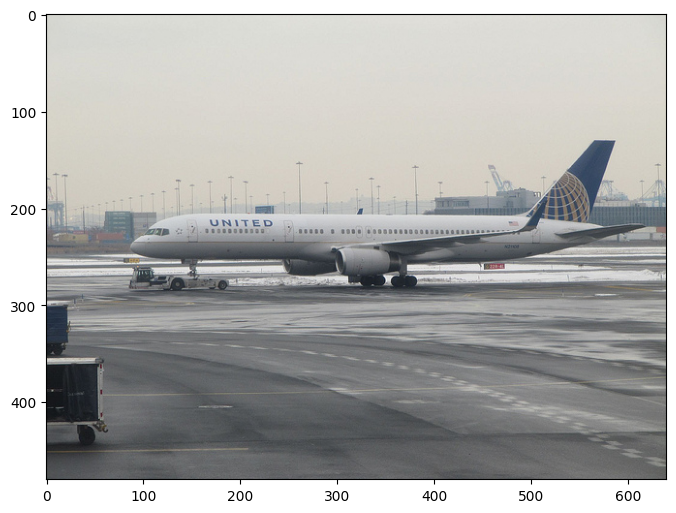

In [ ]:
photo = extract_features("/content/testimg1.png")
img = Image.open("/content/testimg1.png")
for caption in dataset[img_paths[i]]:
  print(caption)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 32ms/step



start a bicycle parked next to a bench with a dog on it end


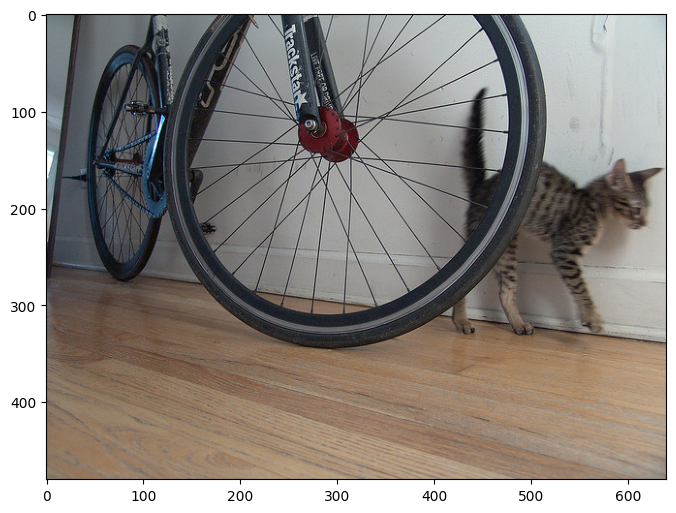

In [ ]:
photo = extract_features("/content/testimg2.png")
img = Image.open("/content/testimg2.png")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 36ms/step



start a large airplane that is sitting on a runway end


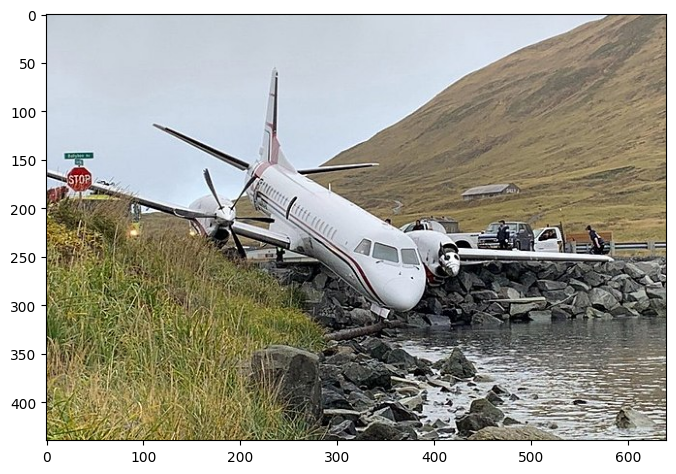

In [ ]:
photo = extract_features("/content/PenAir_Flight_3296（N686PA）_after_crash_landing.jpg")
img = Image.open("/content/PenAir_Flight_3296（N686PA）_after_crash_landing.jpg")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)